/tmp/ipykernel_3692254/2877242083.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})
/tmp/ipykernel_3692254/2877242083.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['JointSnowRounded'] = data['JointSnow'].round().astype(int)
/tmp/ipykernel_3692254/2877242083.py:126: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in f

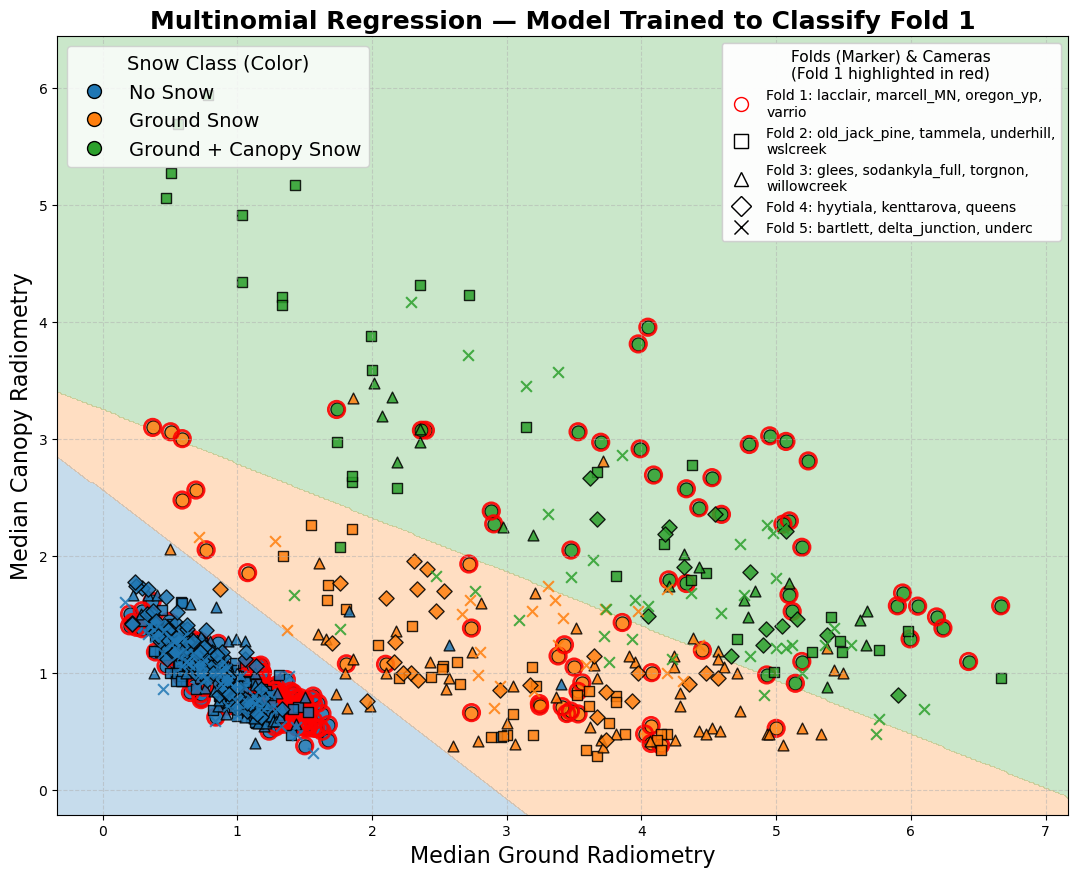

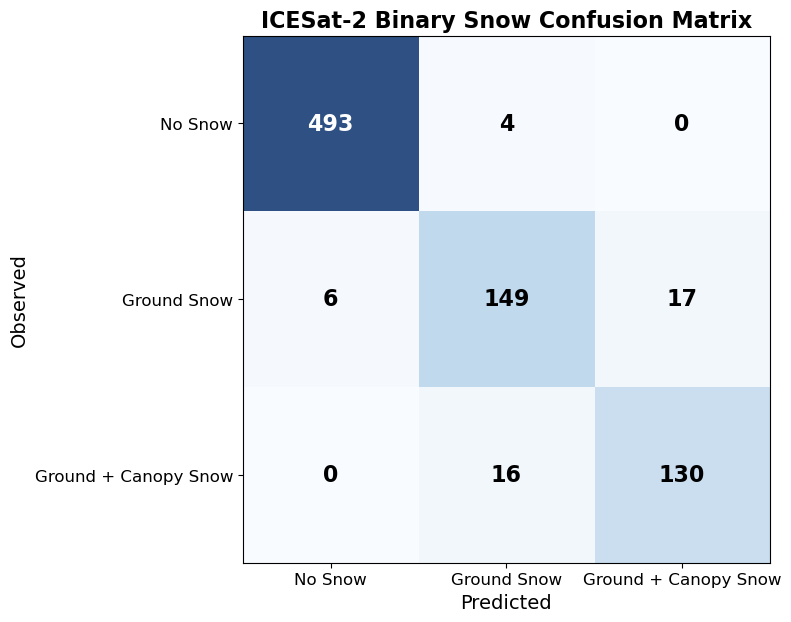

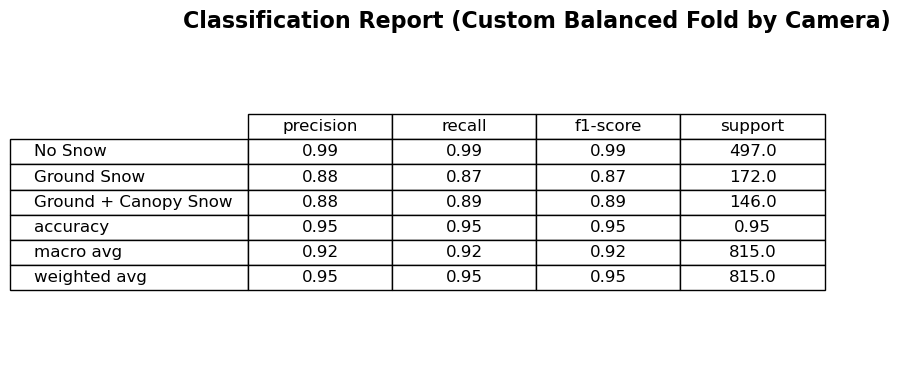

In [1]:
from scripts.imports import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from textwrap import fill

df = pd.read_pickle('dataset_lcforest_LOF_bin15_th3_80m_1kmsmallbox_noprior_ta_v7.pkl')

df['Eg_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier'] == 1), df['Eg'], np.nan)
df['Ev_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier'] == 1), df['Ev'], np.nan)
df['Eg_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Eg'], np.nan)
df['Ev_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Ev'], np.nan)
df['forest_type'] = np.where(df['segment_landcover']<119, 'closed', 'open')

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'Eg_strong': 'median',
    'Ev_strong': 'median',
    'Eg_weak': 'median',
    'Ev_weak': 'median',
    'data_quantity': 'max',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
    'forest_type': lambda x: pd.Series.mode(x).iloc[0],
}).reset_index()
df_grouped = df_grouped[df_grouped['Eg_strong']>=0]
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
data = df_grouped[((df_grouped['FSC'] <= 0.005)|(df_grouped['FSC'] >= 0.995))
    &((df_grouped['TreeSnow'] == 0)|(df_grouped['TreeSnow'] == 1))
    &(df_grouped['Eg_strong']/df_grouped['Eg_weak'] >= 1.15)
    &(df_grouped['data_quantity'] >= 26)]
data.loc[:, 'JointSnow'] = data['JointSnow'].apply(lambda x: np.round(x))
camera_counts = data['camera'].value_counts()

data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from textwrap import fill

# --- Prepare Data ---
data['JointSnowRounded'] = data['JointSnow'].round().astype(int)
features = ['Eg_strong', 'Ev_strong']
target = 'JointSnowRounded'

X = data[features].values
y = data[target].values

# --- Create Custom Balanced GroupKFold on "camera" ---
n_splits = 5

camera_counts = data['camera'].value_counts()
sorted_cameras = camera_counts.index.tolist()

camera_to_fold = {}
for i, cam in enumerate(sorted_cameras):
    camera_to_fold[cam] = i % n_splits

group_indices = data['camera'].map(camera_to_fold).values

# Containers / styling
labels_str = ['No Snow', 'Ground Snow', 'Ground + Canopy Snow']
class_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
group_markers = ['o', 's', '^', 'D', 'x']         # Marker per fold

all_y_true = []
all_y_pred = []

# Keep fold->cameras (for legend block)
fold_to_cameras = {f: [] for f in range(n_splits)}
for cam, f in camera_to_fold.items():
    fold_to_cameras[f].append(cam)

# --- Cross-validation to gather overall metrics (unchanged) ---
for fold_idx in range(n_splits):
    test_idx = np.where(group_indices == fold_idx)[0]
    train_idx = np.where(group_indices != fold_idx)[0]

    cv_model = LogisticRegression(solver='lbfgs',
                                  max_iter=1000, random_state=42, penalty=None)
    cv_model.fit(X[train_idx], y[train_idx])
    y_pred = cv_model.predict(X[test_idx])

    all_y_true.extend(y[test_idx])
    all_y_pred.extend(y_pred)

# === NEW: Train the "final_model" specifically for predicting Fold 1 (index 0) ===
first_fold = 0
first_test_idx = np.where(group_indices == first_fold)[0]
first_train_idx = np.where(group_indices != first_fold)[0]

final_model = LogisticRegression(solver='lbfgs',
                                 max_iter=1000, random_state=42, penalty=None)
final_model.fit(X[first_train_idx], y[first_train_idx])

# --- Mesh for decision boundary using the Fold 1 model ---
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                     np.linspace(y_min, y_max, 400))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = final_model.predict(grid).reshape(xx.shape)

# --- Plot ---
fig, ax = plt.subplots(figsize=(11, 9))
plt.rcParams.update({'font.size': 14})

# Decision boundary background (Fold 1 model)
ax.contourf(xx, yy, Z, alpha=0.25, levels=[-0.5, 0.5, 1.5, 2.5], colors=class_colors)

# Overlay all data; highlight Fold 1 points
for fold in range(n_splits):
    for cls in [0, 1, 2]:
        mask = (group_indices == fold) & (y == cls)
        # Base points
        ax.scatter(X[mask, 0], X[mask, 1],
                   color=class_colors[cls],
                   marker=group_markers[fold],
                   edgecolor='k',
                   s=60 if fold != first_fold else 90,   # larger for Fold 1
                   alpha=0.85)
        # Add a red halo for Fold 1 points to highlight
        if fold == first_fold and np.any(mask):
            ax.scatter(X[mask, 0], X[mask, 1],
                       facecolors='none',
                       edgecolors='red',
                       linewidths=2.0,
                       marker=group_markers[fold],
                       s=140,
                       alpha=0.9)

# --- Class legend (color) ---
class_handles = [
    plt.Line2D([0], [0], marker='o', linestyle='',
               markerfacecolor=class_colors[i], markeredgecolor='k', markersize=10)
    for i in range(3)
]
class_legend = ax.legend(class_handles, labels_str,
                         title='Snow Class (Color)', loc='upper left', frameon=True)
ax.add_artist(class_legend)

# --- Combined Fold (marker) + camera list block in TOP RIGHT ---
fold_handles = []
fold_labels = []
wrap_width = 44

for f in range(n_splits):
    # red edge for Fold 1 in legend too
    handle = plt.Line2D([0], [0], marker=group_markers[f], linestyle='',
                        markerfacecolor='white',
                        markeredgecolor=('red' if f == first_fold else 'k'),
                        markersize=10, linewidth=2)
    cams = sorted(fold_to_cameras[f])
    cams_text = ", ".join(cams) if cams else "(no cameras)"
    label = f"Fold {f+1}: {cams_text}"
    fold_handles.append(handle)
    fold_labels.append(fill(label, width=wrap_width))

fold_legend = ax.legend(fold_handles, fold_labels,
                        title='Folds (Marker) & Cameras\n(Fold 1 highlighted in red)',
                        loc='upper right', frameon=True, fontsize=10, title_fontsize=11)
ax.add_artist(fold_legend)

# --- Labels ---
ax.set_xlabel('Median Ground Radiometry', fontsize=16)
ax.set_ylabel('Median Canopy Radiometry', fontsize=16)
ax.set_title('Multinomial Regression — Model Trained to Classify Fold 1',
             fontsize=18, weight='bold')
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# --- Confusion Matrix (All folds) ---
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(all_y_true, all_y_pred)
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, cmap='Blues', alpha=0.85)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', fontsize=16, fontweight='bold',
                color='white' if cm[i, j] > cm.max()/2 else 'black')

ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(3))
ax.set_xticklabels(labels_str, fontsize=12)
ax.set_yticklabels(labels_str, fontsize=12)
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('Observed', fontsize=14)
plt.title('ICESat-2 Binary Snow Confusion Matrix', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

# --- Classification Report (All folds) ---
from sklearn.metrics import classification_report
report_dict = classification_report(all_y_true, all_y_pred,
                                    target_names=labels_str, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose().round(2)

fig, ax = plt.subplots(figsize=(9, 4))
ax.axis('off')
table = ax.table(cellText=report_df.values,
                 colLabels=report_df.columns,
                 rowLabels=report_df.index,
                 loc='center',
                 cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.4)
plt.title('Classification Report (Custom Balanced Fold by Camera)', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()


=== Bootstrap 1/5 ===

Chosen filter -> Eg_strong/Eg_weak e 1.30, data_quantity e 34 | CV acc=0.9510, CV bin acc=0.9755, n_rows(dedup)=408
OOB cameras: ['kenttarova', 'oregon_yp', 'queens', 'torgnon', 'underc', 'varrio', 'wslcreek']
OOB n=263 | RMSE=0.1396 | Bias=0.0769 | FracRMSE=0.1277 | FracBias=-0.0252
7.08s

=== Bootstrap 2/5 ===

Chosen filter -> Eg_strong/Eg_weak e 1.15, data_quantity e 29 | CV acc=0.9557, CV bin acc=0.9908, n_rows(dedup)=542
OOB cameras: ['bartlett', 'lacclair', 'old_jack_pine', 'sodankyla_full', 'torgnon', 'willowcreek']
OOB n=270 | RMSE=0.1928 | Bias=0.0119 | FracRMSE=0.3265 | FracBias=-0.1425
7.65s

=== Bootstrap 3/5 ===

Chosen filter -> Eg_strong/Eg_weak e 1.14, data_quantity e 29 | CV acc=0.9294, CV bin acc=0.9727, n_rows(dedup)=439
OOB cameras: ['bartlett', 'kenttarova', 'marcell_MN', 'oregon_yp', 'sodankyla_full', 'torgnon', 'varrio']
OOB n=367 | RMSE=0.1488 | Bias=0.0635 | FracRMSE=0.2514 | FracBias=-0.1269
7.45s

=== Bootstrap 4/5 ===

Chosen filter 

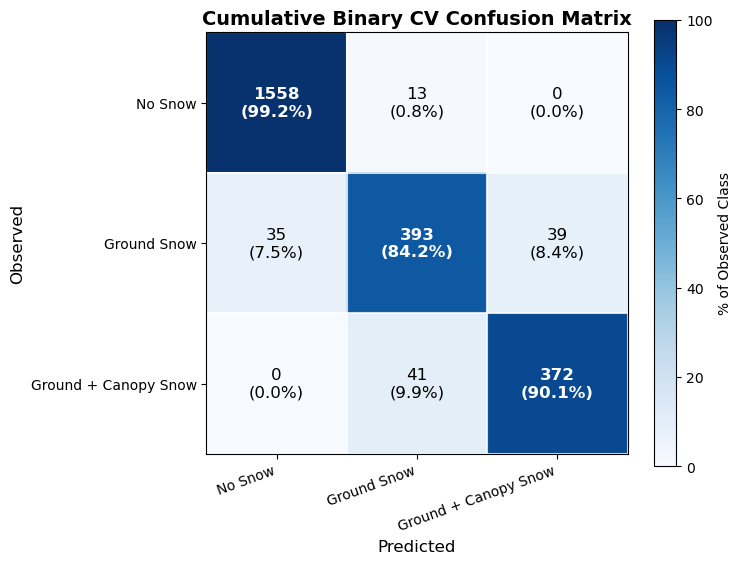

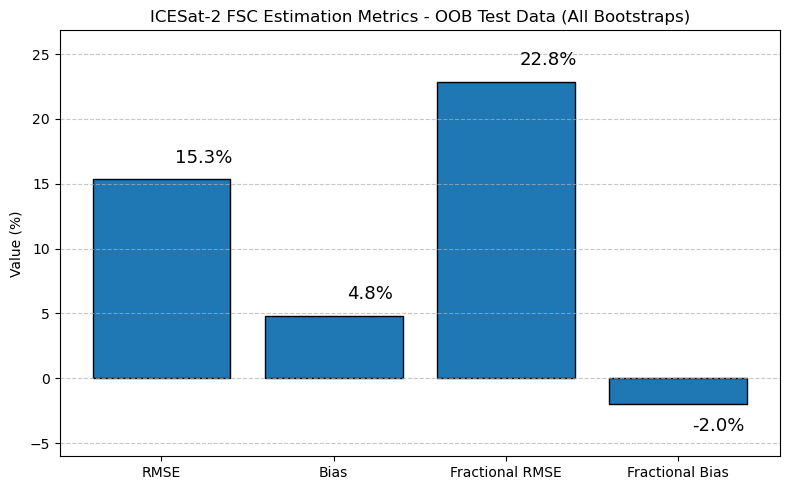

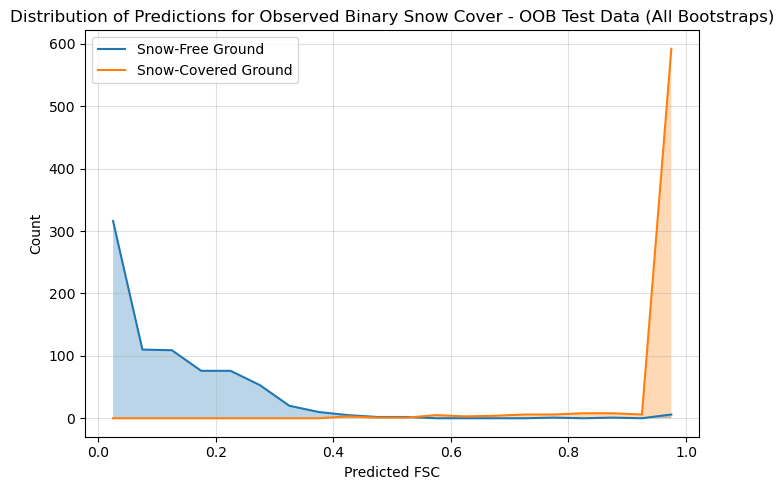

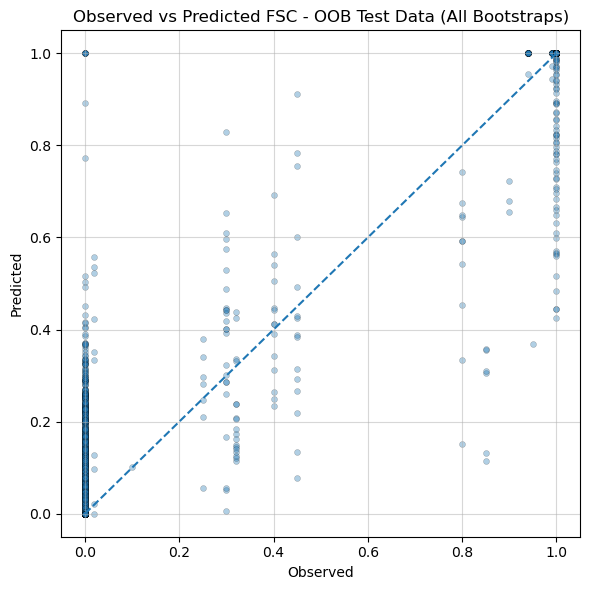

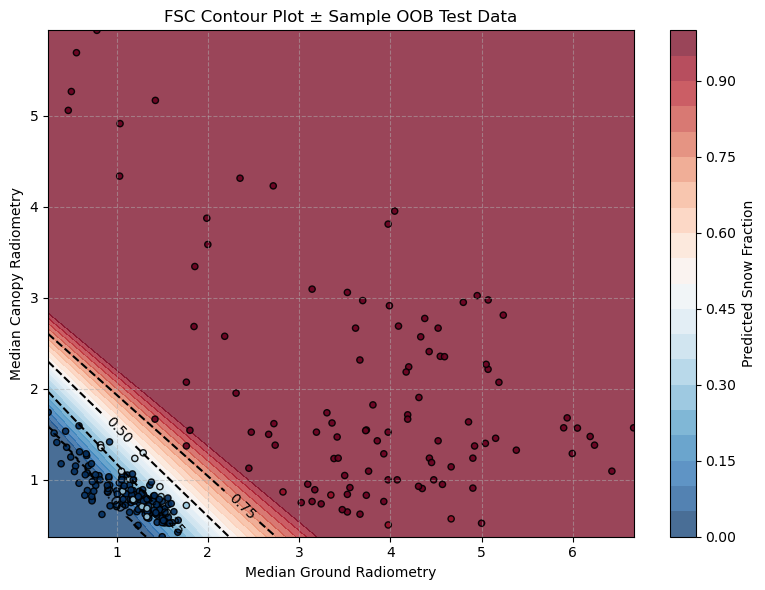

In [9]:
from scripts.imports import *
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from textwrap import fill

df = pd.read_pickle('dataset_lcforest_LOF_bin15_th3_80m_1kmsmallbox_noprior_ta_v7.pkl')

df['Eg_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier'] == 1), df['Eg'], np.nan)
df['Ev_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier'] == 1), df['Ev'], np.nan)
df['Eg_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Eg'], np.nan)
df['Ev_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Ev'], np.nan)
df['forest_type'] = np.where(df['segment_landcover']<119, 'closed', 'open')

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'Eg_strong': 'median',
    'Ev_strong': 'median',
    'Eg_weak': 'median',
    'Ev_weak': 'median',
    'data_quantity': 'max',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
    'forest_type': lambda x: pd.Series.mode(x).iloc[0],
}).reset_index()
df_grouped = df_grouped[df_grouped['Eg_strong']>=0]
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']


# ===========================================================
# PHASE 2: Bootstrap -> optimize filters on DEDUP -> train
#          angular model on DUPLICATED boot set (NEW base cond)
#          -> predict on OOB cameras
# ===========================================================
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy.optimize import minimize

# ------------------------------ config ------------------------------
EG_COL = "Eg_strong"
EV_COL = "Ev_strong"
Y_BIN_COL  = "JointSnowBinary"
FRAC_W = 1.0              # weight for fractional 0<y<1 in RMSE
N_BOOT = 5
N_SPLITS_CV = 5
RATIO_GRID = np.round(np.arange(1.01, 1.30 + 1e-9, 0.01), 2)  # 1.01..1.30
DQ_GRID    = np.arange(20, 36)                                 # 20..35
TOL_NEAR   = 0.003
RNG = np.random.RandomState(42)

# ------------------------------ helper base conditions ------------------------------
# (A) Base conditions for FILTER OPTIMIZATION (deduplicated train slice), as before:
def base_conditions_opt(df):
    return (
        ((df['FSC'] <= 0.005) | (df['FSC'] >= 0.995)) &
        ((df['TreeSnow'] == 0) | (df['TreeSnow'] == 1)) &
        (df['Eg_strong'] >= 0)
    )

# (B) NEW base conditions for the FINAL BOOTSTRAP (duplicated) dataset:
def base_conditions_boot(df):
    # Using the AND (inclusive bounds)  matches your working snippet
    return ((df['FSC'] >= 0.0) & (df['FSC'] <= 1.0) & (df['Eg_strong'] >= 0))

def apply_filters_for_search(df, ratio_thresh, dq_thresh):
    cond = base_conditions_opt(df) & ((df['Eg_strong']/df['Eg_weak']) >= ratio_thresh) & (df['data_quantity'] >= dq_thresh)
    out = df.loc[cond].copy()
    out['JointSnow'] = out['FSC'] + out['TreeSnow']
    out['JointSnowRounded'] = np.round(out['JointSnow']).astype(int)
    return out

def apply_filters_for_boot(df, ratio_thresh, dq_thresh):
    cond = base_conditions_boot(df) & ((df['Eg_strong']/df['Eg_weak']) >= ratio_thresh) & (df['data_quantity'] >= dq_thresh)
    out = df.loc[cond].copy()
    out['JointSnow'] = out['FSC'] + out['TreeSnow']
    # Binary target for angular model: 1 if >=1 else keep 0
    out['JointSnowBinary'] = out['JointSnow'].apply(lambda x: 1 if x >= 1 else x).astype(float)
    return out

# ------------------------------ CV metrics for filter search ------------------------------
def assign_folds_by_camera(df, n_splits=5):
    """
    Round-robin assignment by camera frequency (stable, simple).
    Returns an array of fold indices aligned to df rows.
    """
    counts = df['camera'].value_counts()
    cams_sorted = counts.index.tolist()
    cam2fold = {cam: (i % n_splits) for i, cam in enumerate(cams_sorted)}
    return df['camera'].map(cam2fold).to_numpy()

def cv_multinomial_metrics(df, features=('Eg_strong','Ev_strong'), n_splits=5):
    """
    Camera-grouped CV for 3-class target (0,1,2).
    Returns:
      - multiclass accuracy (float)
      - 3x3 confusion matrix aggregated across folds (np.ndarray)
      - binary accuracy where classes {1,2} are collapsed to 1 vs class {0} (float)
    """
    # Basic viability checks
    if df.shape[0] == 0 or df['JointSnowRounded'].nunique() < 2:
        return np.nan, None, np.nan

    n_unique_cams = df['camera'].nunique()
    n_splits_eff = max(2, min(n_splits, n_unique_cams))

    grp = assign_folds_by_camera(df, n_splits_eff)
    X = df.loc[:, list(features)].to_numpy()
    y = df['JointSnowRounded'].to_numpy()

    valid = np.isfinite(X).all(axis=1) & np.isfinite(y)
    if not np.any(valid):
        return np.nan, None, np.nan
    X, y, grp = X[valid], y[valid], grp[valid]

    if np.unique(y).size < 2:
        return np.nan, None, np.nan

    all_true, all_pred = [], []

    for f in range(n_splits_eff):
        test_mask  = (grp == f)
        train_mask = ~test_mask
        if not np.any(test_mask) or not np.any(train_mask):
            continue

        Xtr, ytr = X[train_mask], y[train_mask]
        Xte, yte = X[test_mask],  y[test_mask]

        if np.unique(ytr).size < 2:
            continue

        model = LogisticRegression(
            solver='lbfgs',
            max_iter=1000,
            random_state=0
        )
        model.fit(Xtr, ytr)
        yhat = model.predict(Xte)
        all_true.extend(yte.tolist())
        all_pred.extend(yhat.tolist())

    if len(all_true) == 0:
        return np.nan, None, np.nan

    all_true = np.asarray(all_true)
    all_pred = np.asarray(all_pred)

    # Multiclass accuracy and confusion matrix (3x3)
    acc = accuracy_score(all_true, all_pred)
    cm = confusion_matrix(all_true, all_pred, labels=[0,1,2])

    # Binary accuracy: collapse {1,2} -> 1 vs {0} -> 0
    y_true_bin = (all_true >= 1).astype(int)
    y_pred_bin = (all_pred >= 1).astype(int)
    bin_acc = accuracy_score(y_true_bin, y_pred_bin)

    return acc, cm, bin_acc

def grid_search_dedup(dedup_train, ratio_grid, dq_grid):
    rows = []
    for r in ratio_grid:
        for dq in dq_grid:
            df_f = apply_filters_for_search(dedup_train, r, dq)
            acc, cm, bin_acc = cv_multinomial_metrics(df_f)
            rows.append({
                'ratio': r,
                'dq': int(dq),
                'accuracy': acc,
                'bin_acc': bin_acc,
                'n_rows': int(len(df_f)),
                'conf_mat': cm  # np.ndarray or None
            })
    res = pd.DataFrame(rows).dropna(subset=['accuracy']).reset_index(drop=True)
    return res

def choose_best(res, tol=0.002):
    """
    Choose among combos within tol of best multiclass accuracy:
    priority: largest n_rows, then higher accuracy, then smaller ratio, then smaller dq.
    Returns: chosen_row_as_dict (including 'conf_mat', 'bin_acc'), near_df
    """
    if res.empty:
        return None, pd.DataFrame(columns=res.columns)
    best = res['accuracy'].max()
    near = res[res['accuracy'] >= best - tol].copy()
    near = near.sort_values(['n_rows','accuracy','ratio','dq'],
                            ascending=[False, False, True, True]).reset_index(drop=True)
    return near.iloc[0].to_dict(), near

# ------------------------------ Angular model (with BIN_W_GROUP) ------------------------------
def mod2pi(x): return np.mod(x, 2*np.pi)
def dccw(a, b): return mod2pi(b - a)

def angular_sector_map(eg, ev, cx, cy, theta1, theta2, eps=1e-9):
    eg = np.asarray(eg); ev = np.asarray(ev)
    theta = mod2pi(np.arctan2(ev - cy, eg - cx))
    t1 = mod2pi(theta1); t2 = mod2pi(theta2); pi_m = mod2pi(np.pi)
    arc = dccw(t1, t2); arc = np.maximum(arc, eps)
    d1 = dccw(t1, theta)
    in_grad = d1 <= arc + eps
    vals = np.empty_like(theta, dtype=float)
    vals[in_grad] = np.clip(d1[in_grad] / arc, 0.0, 1.0)
    d_from_t2 = dccw(t2, theta)
    d_t2_to_pi = dccw(t2, pi_m)
    in_high = (~in_grad) & (d_from_t2 < d_t2_to_pi - eps)
    vals[in_high] = 1.0
    vals[~(in_grad | in_high)] = 0.0
    at_pi = np.isclose(mod2pi(theta), pi_m, atol=1e-12); vals[at_pi] = 0.0
    at_center = np.isclose(eg, cx, atol=1e-12) & np.isclose(ev, cy, atol=1e-12); vals[at_center] = 0.0
    return vals

def tiny_arc_penalty(theta1, theta2, thresh=1e-3):
    arc = dccw(mod2pi(theta1), mod2pi(theta2))
    return 1e6 * (thresh - arc + 1e-9) if arc < thresh else 0.0

def weighted_rmse(y_true, y_pred, frac_weight=1.0, bin_weight=0.25):
    y_true = np.asarray(y_true, dtype=float); y_pred = np.asarray(y_pred, dtype=float)
    w = np.where((y_true > 0) & (y_true < 1), frac_weight, bin_weight)
    return np.sqrt(np.sum(w * (y_true - y_pred) ** 2) / np.sum(w))

def fit_sector_model_with_group_binw(train_df):
    data = train_df.dropna(subset=[EG_COL, EV_COL, Y_BIN_COL]).copy()
    eg = data[EG_COL].values; ev = data[EV_COL].values; y = data[Y_BIN_COL].astype(float).values

    # Compute BIN_W from the bootstrapped training y
    n_frac_total = int(((y > 0) & (y < 1)).sum())
    n_bin_total  = int(len(y) - n_frac_total)
    BIN_W_GROUP  = (n_frac_total / n_bin_total) if n_bin_total > 0 and n_frac_total > 0 else 1.0

    def init_params():
        return np.array([0.0, 1.8, -np.pi/4, -np.pi/8], dtype=float)

    bounds = [(-np.inf, 0.0), (max(1e-6, 0.0), np.inf), (-np.pi/2, np.pi), (-np.pi, 0.0)]

    def objective(p):
        cx, cy, t1, t2 = p
        y_hat = angular_sector_map(eg, ev, cx, cy, t1, t2)
        return weighted_rmse(y, y_hat, frac_weight=FRAC_W, bin_weight=BIN_W_GROUP) + tiny_arc_penalty(t1, t2)

    res = minimize(objective, init_params(), method="L-BFGS-B", bounds=bounds)
    cx, cy, t1, t2 = res.x
    params = {"cx": cx, "cy": cy, "theta1": t1, "theta2": t2, "BIN_W_GROUP": BIN_W_GROUP}
    return params

def predict_sector(df, params):
    eg = df[EG_COL].values; ev = df[EV_COL].values
    p  = angular_sector_map(eg, ev, params["cx"], params["cy"], params["theta1"], params["theta2"])
    return np.clip(p, 0.0, 1.0)

def compute_metrics(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float); y_pred = np.asarray(y_pred, dtype=float)
    overall_rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    overall_bias = float(np.mean(y_pred - y_true))
    frac_mask = (y_true > 0) & (y_true < 1)
    frac_rmse = float(np.sqrt(mean_squared_error(y_true[frac_mask], y_pred[frac_mask]))) if np.any(frac_mask) else np.nan
    frac_bias = float(np.mean(y_pred[frac_mask] - y_true[frac_mask])) if np.any(frac_mask) else np.nan
    return dict(
        overall_rmse=overall_rmse, overall_bias=overall_bias,
        overall_frac_rmse=frac_rmse, overall_frac_bias=frac_bias
    )

# ------------------------------ bootstrap loop ------------------------------
all_cameras = sorted(df_grouped['camera'].unique())
assert len(all_cameras) == 18, f"Expected 18 unique cameras, found {len(all_cameras)}."

phase2_rows = []
# Collect OOB predictions from ALL bootstraps
all_oob_y_true = []
all_oob_y_pred = []

# Accumulate chosen-config CV confusion matrices across bootstraps
cumulative_cv_conf_mat = np.zeros((3,3), dtype=int)

sample_oob_df = None  # keep your sample capture for contour

for b in range(N_BOOT):
    start = time.time()
    
    sampled_cams = RNG.choice(all_cameras, size=len(all_cameras), replace=True)
    sampled_unique = sorted(set(sampled_cams))
    oob_cams = sorted(set(all_cameras) - set(sampled_unique))

    # Build duplicated bootstrap frame (concat each sampled camera once per draw)
    boot_concat = pd.concat([df_grouped[df_grouped['camera'] == cam] for cam in sampled_cams],
                            ignore_index=True)

    # Dedup train for filter search
    dedup_train = df_grouped[df_grouped['camera'].isin(sampled_unique)].copy()

    # Grid search on deduplicated train (original base conditions)
    res = grid_search_dedup(dedup_train, RATIO_GRID, DQ_GRID)
    chosen, near = choose_best(res, tol=TOL_NEAR)

    print(f"\n=== Bootstrap {b+1}/{N_BOOT} ===")
    if chosen is None:
        print("No valid filter produced a trainable dataset for search.")
        phase2_rows.append({
            'bootstrap': b+1, 'ratio': np.nan, 'dq': np.nan,
            'n_rows_search': 0, 'n_rows_boot_train': 0, 'n_rows_oob': 0,
            'oob_rmse': np.nan, 'oob_bias': np.nan, 'oob_frac_rmse': np.nan, 'oob_frac_bias': np.nan,
            'n_oob_cameras': len(oob_cams),
            'cv_acc': np.nan,
            'cv_bin_acc': np.nan
        })
        continue

    print(f"\nChosen filter -> Eg_strong/Eg_weak e {chosen['ratio']:.2f}, data_quantity e {int(chosen['dq'])} "
          f"| CV acc={chosen['accuracy']:.4f}, CV bin acc={chosen['bin_acc']:.4f}, n_rows(dedup)={int(chosen['n_rows'])}")

    # Update cumulative CV confusion matrix (3x3) for the chosen combo
    if isinstance(chosen.get('conf_mat', None), np.ndarray):
        cumulative_cv_conf_mat += chosen['conf_mat'].astype(int)

    # Apply chosen filter to the duplicated boot set using NEW base conditions
    boot_train = apply_filters_for_boot(boot_concat, chosen['ratio'], int(chosen['dq']))

    # Fit angular sector model with BIN_W_GROUP from this bootstrapped training set
    if len(boot_train) == 0:
        print("Bootstrapped training set empty after filters; skipping.")
        phase2_rows.append({
            'bootstrap': b+1, 'ratio': float(chosen['ratio']), 'dq': int(chosen['dq']),
            'n_rows_search': int(chosen['n_rows']), 'n_rows_boot_train': 0, 'n_rows_oob': 0,
            'oob_rmse': np.nan, 'oob_bias': np.nan, 'oob_frac_rmse': np.nan, 'oob_frac_bias': np.nan,
            'n_oob_cameras': len(oob_cams),
            'cv_acc': float(chosen['accuracy']),
            'cv_bin_acc': float(chosen['bin_acc'])
        })
        continue

    params = fit_sector_model_with_group_binw(boot_train)

    # Build OOB dataframe (no duplicates) and apply same chosen filter with NEW base conditions
    oob_df = df_grouped[df_grouped['camera'].isin(oob_cams)].copy()
    oob_df = apply_filters_for_boot(oob_df, chosen['ratio'], int(chosen['dq']))

    # Predict on OOB cameras
    if len(oob_df) > 0:
        y_pred = predict_sector(oob_df, params)
        y_true = oob_df[Y_BIN_COL].astype(float).values

        # Accumulate all OOB predictions across bootstraps
        all_oob_y_true.append(y_true.copy())
        all_oob_y_pred.append(y_pred.copy())

        # Capture first successful sample for plotting later
        if ('sample_oob_df' not in globals()) or (sample_oob_df is None):
            sample_oob_df = oob_df.copy()
            sample_params = params
            sample_y_true = y_true.copy()
            sample_y_pred = y_pred.copy()
        
        m = compute_metrics(y_true, y_pred)
        print(f"OOB cameras: {oob_cams if oob_cams else ' none (all cameras sampled)'}")
        print(f"OOB n={len(oob_df)} | RMSE={m['overall_rmse']:.4f} | Bias={m['overall_bias']:.4f} | "
              f"FracRMSE={m['overall_frac_rmse'] if np.isfinite(m['overall_frac_rmse']) else np.nan:.4f} | "
              f"FracBias={m['overall_frac_bias'] if np.isfinite(m['overall_frac_bias']) else np.nan:.4f}")
    else:
        m = dict(overall_rmse=np.nan, overall_bias=np.nan, overall_frac_rmse=np.nan, overall_frac_bias=np.nan)
        print("No OOB rows after filtering (all cameras sampled and/or filtered out).")

    phase2_rows.append({
        'bootstrap': b+1,
        'ratio': float(chosen['ratio']),
        'dq': int(chosen['dq']),
        'n_rows_search': int(chosen['n_rows']),
        'n_rows_boot_train': int(len(boot_train)),
        'n_rows_oob': int(len(oob_df)),
        'oob_rmse': m['overall_rmse'],
        'oob_bias': m['overall_bias'],
        'oob_frac_rmse': m['overall_frac_rmse'],
        'oob_frac_bias': m['overall_frac_bias'],
        'n_oob_cameras': len(oob_cams),
        'bin_w_group': params.get('BIN_W_GROUP', np.nan),
        # CV metrics for reference/averaging
        'cv_acc': float(chosen['accuracy']),
        'cv_bin_acc': float(chosen['bin_acc'])
    })

    end = time.time()
    print(f"{round(end-start,2)}s")

# ------------------------------ summary ------------------------------
phase2_df = pd.DataFrame(phase2_rows)

print("\n====================")
print("\nFilter choice frequency across bootstraps:")
freq = (phase2_df
        .dropna(subset=['ratio','dq'])
        .value_counts(subset=['ratio','dq'])
        .reset_index(name='count')
        .sort_values('count', ascending=False))
print(freq.to_string(index=False))

print("\nOOB metrics (mean ± std) across bootstraps (ignoring NaNs):")
def mean_std(series): 
    return f"{np.nanmean(series):.4f} ± {np.nanstd(series):.4f}"
print("RMSE:      ", mean_std(phase2_df['oob_rmse']))
print("Bias:      ", mean_std(phase2_df['oob_bias']))
print("Frac RMSE: ", mean_std(phase2_df['oob_frac_rmse']))
print("Frac Bias: ", mean_std(phase2_df['oob_frac_bias']))

print("\nCV metrics (mean ± std across chosen filters per bootstrap):")
print("Multiclass accuracy: ", mean_std(phase2_df['cv_acc']))
print("Binary accuracy (0 vs {1,2}): ", mean_std(phase2_df['cv_bin_acc']))

# --- Cumulative CV confusion matrix (3x3) PLOT ---
cm = cumulative_cv_conf_mat.astype(float)
# Row-normalize to percentages
row_sums = cm.sum(axis=1, keepdims=True)
pct = np.divide(cm, row_sums, out=np.zeros_like(cm), where=row_sums != 0) * 100.0

labels = ["No Snow", "Ground Snow", "Ground + Canopy Snow"]

fig, ax = plt.subplots(figsize=(7.5, 6))
im = ax.imshow(pct, cmap="Blues", vmin=0, vmax=100)

# Annotate each cell with counts and row-normalized %
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = int(cm[i, j])
        perc  = pct[i, j]
        ax.text(
            j, i,
            f"{count}\n({perc:.1f}%)",
            ha="center", va="center",
            fontsize=12,
            color="white" if perc > 50 else "black",
            fontweight="bold" if perc > 50 else "normal"
        )

# Axes labels/ticks
ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(3))
ax.set_xticklabels(labels, rotation=20, ha="right")
ax.set_yticklabels(labels)
ax.set_xlabel("Predicted", fontsize=12)
ax.set_ylabel("Observed", fontsize=12)
ax.set_title("Cumulative Binary CV Confusion Matrix", fontsize=14, weight="bold")

# Colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("% of Observed Class", rotation=90)

# Grid lines to separate cells
ax.set_xticks(np.arange(-.5, 3, 1), minor=True)
ax.set_yticks(np.arange(-.5, 3, 1), minor=True)
ax.grid(which="minor", color="white", linestyle="-", linewidth=1.5, alpha=0.8)
ax.tick_params(which="minor", bottom=False, left=False)

plt.tight_layout()
plt.show()


# =============================
# VISUALIZATION (all bootstraps)
# =============================
import matplotlib.pyplot as plt

# --- 1) Overall OOB metrics bar chart (means across bootstraps) ---
overall_rmse      = float(np.nanmean(phase2_df['oob_rmse']))
overall_bias      = float(np.nanmean(phase2_df['oob_bias']))
overall_frac_rmse = float(np.nanmean(phase2_df['oob_frac_rmse']))
overall_frac_bias = float(np.nanmean(phase2_df['oob_frac_bias']))

metrics = ["RMSE", "Bias", "Fractional RMSE", "Fractional Bias"]
means   = np.array([overall_rmse, overall_bias, overall_frac_rmse, overall_frac_bias]) * 100.0

plt.figure(figsize=(8, 5))
x = np.arange(len(metrics))
bars = plt.bar(x, means, edgecolor='black')

for bar, mean in zip(bars, means):
    height = bar.get_height()
    x_offset = bar.get_x() + bar.get_width() * 0.6
    y_offset = 1 * np.sign(height if height != 0 else 1)
    plt.text(x_offset, height + y_offset, f"{mean:.1f}%",
             ha='left', va='bottom' if height >= 0 else 'top', fontsize=13)

plt.xticks(x, metrics)
plt.ylabel("Value (%)")
plt.title("ICESat-2 FSC Estimation Metrics - OOB Test Data (All Bootstraps)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

ymin = min(0, float(np.nanmin(means))) - 4
ymax = (float(np.nanmax(means)) + 4) if np.nanmax(means) > 0 else 1
plt.ylim(ymin, ymax)

plt.tight_layout()
plt.show()

# --- 2) Combine OOB predictions from ALL bootstraps and plot ---
y_true_all = np.concatenate(all_oob_y_true) if len(all_oob_y_true) else np.array([])
y_pred_all = np.concatenate(all_oob_y_pred) if len(all_oob_y_pred) else np.array([])

def plot_binary_prediction_distribution(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask0 = y_true == 0
    mask1 = y_true == 1

    bins = np.arange(0.0, 1.05, 0.05)
    c0, _ = np.histogram(y_pred[mask0], bins=bins)
    c1, _ = np.histogram(y_pred[mask1], bins=bins)
    centers = 0.5 * (bins[:-1] + bins[1:])

    plt.figure(figsize=(7,5))
    plt.plot(centers, c0, label="Snow-Free Ground")
    plt.fill_between(centers, 0, c0, alpha=0.3)
    plt.plot(centers, c1, label="Snow-Covered Ground")
    plt.fill_between(centers, 0, c1, alpha=0.3)
    plt.xlabel("Predicted FSC")
    plt.ylabel("Count")
    plt.title("Distribution of Predictions for Observed Binary Snow Cover - OOB Test Data (All Bootstraps)")
    plt.legend()
    plt.grid(alpha=0.4)
    plt.tight_layout()
    plt.show()

def plot_obs_vs_pred(y_true, y_pred, title="Observed vs Predicted FSC"):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.35, edgecolor='k', linewidth=0.3, s=18)
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("Observed")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.show()

if y_true_all.size and y_pred_all.size:
    plot_binary_prediction_distribution(y_true_all, y_pred_all)
    plot_obs_vs_pred(y_true_all, y_pred_all, title="Observed vs Predicted FSC - OOB Test Data (All Bootstraps)")

# --- 3) Optional: keep your sample contour using the saved sample params/data ---
GRID_N = 300
def plot_test_contour(test_df, params, title="FSC Estimation ± OOB Test Data"):
    eg = test_df[EG_COL].values
    ev = test_df[EV_COL].values
    y  = test_df[Y_BIN_COL].astype(float).values

    eg_min, eg_max = float(np.min(eg)), float(np.max(eg))
    ev_min, ev_max = float(np.min(ev)), float(np.max(ev))

    eg_vals = np.linspace(eg_min, eg_max, GRID_N)
    ev_vals = np.linspace(ev_min, ev_max, GRID_N)
    EG, EV = np.meshgrid(eg_vals, ev_vals)

    Z = angular_sector_map(EG, EV, params["cx"], params["cy"], params["theta1"], params["theta2"])

    fig, ax = plt.subplots(figsize=(8,6))
    cs = ax.contourf(EG, EV, Z, levels=np.linspace(0,1,21), cmap='RdBu_r', alpha=0.75)
    cbar = fig.colorbar(cs, ax=ax); cbar.set_label("Predicted Snow Fraction")
    lines = ax.contour(EG, EV, Z, levels=[0,0.25,0.5,0.75,1], colors='k', linestyles='--')
    ax.clabel(lines, fmt='%1.2f')

    ax.scatter(eg, ev, c=y, cmap='RdBu_r', edgecolor='k', s=20, vmin=0, vmax=1, alpha=0.9)
    ax.set_xlabel("Median Ground Radiometry")
    ax.set_ylabel("Median Canopy Radiometry")
    ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

if sample_oob_df is not None:
    plot_test_contour(sample_oob_df, sample_params, title="FSC Contour Plot ± Sample OOB Test Data")

# combining plots from landsat and icesat-2

In [10]:
from scripts.imports import *
from rasterio.enums import Resampling
from shapely.geometry import Polygon, Point

def find_masks(folder, cam):
    for filename in os.listdir(folder):
        if cam in filename and 'LandCover' in filename:
            corine_filepath = os.path.join(folder, filename)
        elif cam in filename and 'ALOS' in filename:
            elevation_filepath = os.path.join(folder, filename)
    return corine_filepath, elevation_filepath

def load_and_reproject_to_landsat(source_path, match_array, band_name, method=Resampling.nearest):
    src = rioxarray.open_rasterio(source_path, masked=True).squeeze()
    src.name = band_name
    return src.rio.reproject_match(match_array, resampling=method)

def combine_tifs(landsat_filepath, corine_filepath, elevation_filepath):
    landsat = rioxarray.open_rasterio(landsat_filepath, masked=True).squeeze()
    landsat.name = "landsat"
    corine = load_and_reproject_to_landsat(corine_filepath, landsat, "corine_landcover")
    elevation = load_and_reproject_to_landsat(elevation_filepath, landsat, "elevation")
    return xr.merge([landsat, corine, elevation])

def apply_valid_mask(ds, e=80):
    elevation = ds['elevation']
    corine = ds['corine_landcover']
    yc, xc = elevation.sizes['y'] // 2, elevation.sizes['x'] // 2
    centre_elev = elevation.isel(y=yc, x=xc).item()
    elev_mask = np.abs(elevation - centre_elev) <= e
    corine_mask = (corine >= 111) & (corine <= 126)
    valid_mask = elev_mask & corine_mask
    ds['valid_mask'] = valid_mask
    return ds

def compute_ndvi(red, nir):
    return (nir - red) / (nir + red)

def compute_ndsi(green, swir):
    return (green - swir) / (green + swir)

def compute_dozier(ds, ndsi, nir):
    corine = ds['corine_landcover']
    condition1 = (ndsi > 0.1) & (ndsi < 0.4) # & (corine >= 111) & (corine <= 126)
    condition2 = (ndsi >= 0.4) & (nir > 0.11) # ~((corine >= 111) & (corine <= 126))
    dozier = xr.where(condition1 | condition2, 1, 0)
    return dozier.where(~np.isnan(ndsi))

def compute_klein(ndsi, ndvi, green, nir):
    region_coords = [
        (0.4, 1), (0.33, 0.91), (0.26, 0.75),
        (0.2, 0.6), (0.1, 0.25), (0.4, 0.1),
    ]
    polygon = Polygon(region_coords)
    klein = xr.zeros_like(ndsi)
    klein = xr.where(ndsi >= 0.4, 1, klein)
    ndsi_vals, ndvi_vals = ndsi.values, ndvi.values
    mask = np.zeros(ndsi.shape, dtype=bool)
    for i in range(ndsi.shape[0]):
        for j in range(ndsi.shape[1]):
            if not np.isnan(ndsi_vals[i, j]) and not np.isnan(ndvi_vals[i, j]):
                if polygon.contains(Point(ndsi_vals[i, j], ndvi_vals[i, j])):
                    mask[i, j] = True
    klein = xr.where(xr.DataArray(mask, dims=ndsi.dims, coords=ndsi.coords), 1, klein)
    klein = xr.where((green <= 0.1) | (nir <= 0.11), 0, klein)
    return klein.where(~np.isnan(ndsi) & ~np.isnan(ndvi))

def compute_salomonson(ndsi):
    fsc = 0.06 + 1.21 * ndsi
    return fsc.clip(0, 1).where(~np.isnan(ndsi))

def normalize(img):
    img = img.transpose("y", "x", "band")
    p2 = img.quantile(0.02, dim=("x", "y"))
    p98 = img.quantile(0.98, dim=("x", "y"))
    return ((img - p2) / (p98 - p2)).clip(0, 1)

def plot_rgb(ds, landsat, cam, filtered=True):
    rgb_bands = [2, 1, 0] if landsat == 'Landsat7' else [3, 2, 1]
    rgb = ds['landsat'].isel(band=rgb_bands)

    if filtered and 'valid_mask' in ds:
        # Apply valid mask across all bands
        mask = ds['valid_mask']
        rgb = rgb.where(mask)

    rgb = normalize(rgb)

    plt.figure(figsize=(8, 8))
    title = f"RGB Composite for {cam}" + (" (Filtered)" if filtered else " (Raw)")
    plt.imshow(rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()

import os
import re

def process_scene(i, apply_filter=True, plot_rgb_image=True, e=80):
    cams = ['bartlett', 'delta_junction', 'glees', 'hyytiala', 'kenttarova', 'lacclair', 'marcell', 'old_jack_pine',
            'oregon', 'queens', 'sodankyla', 'torgnon', 'underc', 'underhill', 'varrio', 'willowcreek', 'wslcreek']

    landsat_folder = '../scratch/data/landsat/'
    landsat_filepaths = sorted([
        os.path.join(landsat_folder, f) for f in os.listdir(landsat_folder)
        if os.path.isfile(os.path.join(landsat_folder, f))
    ])

    filepath = landsat_filepaths[i]
    cam = [c for c in cams if c in filepath][0]
    landsat = [l for l in ['Landsat7', 'Landsat8'] if l in filepath][0]

    # Extract FSC number from filename (e.g. 'bartlett80_')
    match = re.search(rf"{cam}(\d+)_", os.path.basename(filepath))
    fsc_value = int(match.group(1)) if match else None

    landsat_masking_folder = '../scratch/data/landsat_masking/'
    corine_fp, elev_fp = find_masks(landsat_masking_folder, cam)
    print(f"Processing i={i}: {filepath}")
    
    ds = combine_tifs(filepath, corine_fp, elev_fp)
    ds = apply_valid_mask(ds, e)

    bgrns = [1, 2, 3, 4, 5] if landsat == 'Landsat7' else [2, 3, 4, 5, 6]
    red, green, blue, nir, swir = [ds['landsat'].isel(band=b - 1) for b in bgrns]

    ndsi = compute_ndsi(green, swir)
    ndvi = compute_ndvi(red, nir)

    dozier = compute_dozier(ds, ndsi, nir)
    klein = compute_klein(ndsi, ndvi, green, nir)
    fsc = compute_salomonson(ndsi)
    if apply_filter:
        dozier = dozier.where(ds['valid_mask'])
        klein = klein.where(ds['valid_mask'])
        fsc = fsc.where(ds['valid_mask'])
    
    ds['Dozier'] = dozier.assign_attrs(name="Dozier")
    ds['Klein'] = klein.assign_attrs(name="Klein")
    ds['Salomonson'] = fsc.assign_attrs(name="Salomonson")

    if plot_rgb_image:
        plot_rgb(ds, landsat, cam, filtered=False)

    return ds, fsc_value, cam

def subcell_stats(ds, var='Salomonson', apply_filter=True, extent=4):
    """
    Compute mean value and valid_mask fraction in fixed 8x8 grid over dataset in meters.

    Args:
        ds (xr.Dataset): Dataset with 2D variable `var` and 'valid_mask'
        var (str): Variable to average (default: 'Salomonson')
        apply_filter (bool): If True, use 'valid_mask' to filter pixels before averaging

    Returns:
        pd.DataFrame with columns: ['cell_y', 'cell_x', 'mean', 'filtered_fraction']
    """
    data = ds[var]
    mask = ds['valid_mask']

    # Get coordinates
    y_vals = data['y'].values
    x_vals = data['x'].values
    yy, xx = np.meshgrid(y_vals, x_vals, indexing="ij")

    flat_y = yy.ravel()
    flat_x = xx.ravel()
    flat_data = data.values.ravel()
    flat_mask = mask.values.ravel()

    # Get bounding box and define 8 even bins in each direction
    y_min, y_max = y_vals.min(), y_vals.max()
    x_min, x_max = x_vals.min(), x_vals.max()

    y_edges = np.linspace(y_min, y_max, 9)  # 8 bins = 9 edges
    x_edges = np.linspace(x_min, x_max, 9)

    # Digitize assigns bin 1–8; subtract 1 → 0–7 for indexing
    cell_y = np.digitize(flat_y, y_edges) - 1
    cell_x = np.digitize(flat_x, x_edges) - 1

    # Keep only points within bin ranges
    valid = (cell_y >= 4 - extent) & (cell_y < 4 + extent) & (cell_x >= 4 - extent) & (cell_x < 4 + extent)

    df = pd.DataFrame({
        'cell_y': cell_y[valid],
        'cell_x': cell_x[valid],
        'data': flat_data[valid],
        'mask': flat_mask[valid]
    })

    # if apply_filter:
    #     df = df[df['mask'] == True]

    grouped = df.groupby(['cell_y', 'cell_x'], as_index=False).agg(
        mean=('data', 'mean'),
        filtered_fraction=('mask', lambda v: np.count_nonzero(v == True) / np.count_nonzero(~np.isnan(v)))
        if apply_filter else
        ('mask', lambda v: 1.0)  # If not filtering, assume full coverage
    )

    return grouped

N = len([f for f in os.listdir('../scratch/data/landsat/') if os.path.isfile(os.path.join('../scratch/data/landsat/', f))])
print(N)

merged_results = []

for i in range(N):  # or range(1) for testing
    ds, fsc, cam = process_scene(i=i, apply_filter=True, plot_rgb_image=False, e=80)
    
    print(fsc)
    fsc_norm = fsc / 100

    # fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
    
    # ds.Dozier.plot(ax=axes[0])
    # axes[0].set_title("Dozier")
    
    # ds.Klein.plot(ax=axes[1])
    # axes[1].set_title("Klein")
    
    # ds.Salomonson.plot(ax=axes[2])
    # axes[2].set_title("Salomonson")
    
    # plt.tight_layout()
    # plt.show()

    # Get results for all three metrics
    dozier = subcell_stats(ds, var='Dozier', apply_filter=True, extent=4)
    klein = subcell_stats(ds, var='Klein', apply_filter=True, extent=4)
    # salo  = subcell_stats(ds, var='Salomonson', apply_filter=True, extent=4)

    # Filter by valid fraction
    dozier = dozier.where(dozier['filtered_fraction'] >= 0.2).dropna()
    klein  = klein.where(klein['filtered_fraction'] >= 0.2).dropna()
    # salo   = salo.where(salo['filtered_fraction'] >= 0.2).dropna()

    # Merge on cell_x and cell_y
    merged = dozier[['cell_y', 'cell_x', 'filtered_fraction', 'mean']].rename(columns={'mean': 'Dozier'}) \
        .merge(klein[['cell_y', 'cell_x', 'mean']].rename(columns={'mean': 'Klein'}), on=['cell_y', 'cell_x']) \
        # .merge(salo[['cell_y', 'cell_x', 'mean']].rename(columns={'mean': 'Salomonson'}), on=['cell_y', 'cell_x'])

    # Add fsc column
    merged['fsc'] = fsc_norm
    merged['cam'] = cam
    merged_results.append(merged)

# Final DataFrame
final_df = pd.concat(merged_results, ignore_index=True)

print(final_df)

58
Processing i=0: ../scratch/data/landsat/Landsat7_bartlett80_clouds4_LE07_L2SP_013029_20220323_20220419_02_T1.tif
80
Processing i=1: ../scratch/data/landsat/Landsat7_hyytiala95_clouds6_LE07_L2SP_189017_20190417_20200827_02_T1.tif
95
Processing i=2: ../scratch/data/landsat/Landsat7_kenttarova98_clouds0_LE07_L2SP_192012_20200526_20200820_02_T1.tif
98
Processing i=3: ../scratch/data/landsat/Landsat7_lacclair90_clouds0_LE07_L2SP_013027_20190502_20200825_02_T1.tif
90
Processing i=4: ../scratch/data/landsat/Landsat7_marcell100_clouds12_LE07_L2SP_028027_20200326_20200822_02_T1.tif
100
Processing i=5: ../scratch/data/landsat/Landsat7_marcell60_clouds0_LE07_L2SP_027027_20210306_20210401_02_T1.tif
60
Processing i=6: ../scratch/data/landsat/Landsat7_marcell70_clouds0_LE07_L2SP_027027_20200404_20200822_02_T1.tif
70
Processing i=7: ../scratch/data/landsat/Landsat7_marcell80_clouds0_LE07_L2SP_028027_20210313_20210410_02_T1.tif
80
Processing i=8: ../scratch/data/landsat/Landsat7_old_jack_pine44_clo

/tmp/ipykernel_3985287/1359689961.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_df = melted.groupby("method", as_index=False).apply(compute_rmse_bias).reset_index(drop=True)


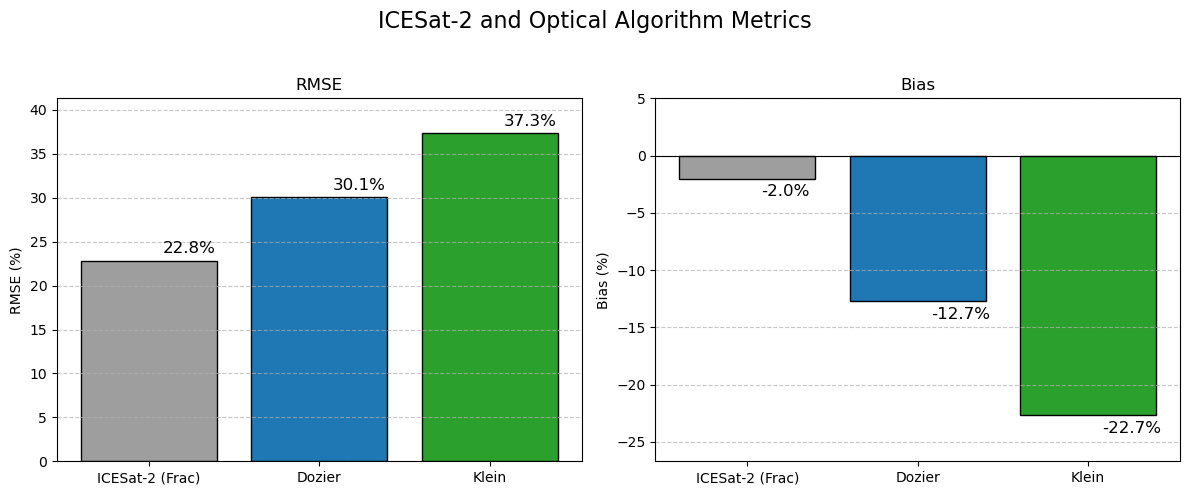

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# Expects these to already exist:
# - final_df with columns ['fsc','filtered_fraction','cam','Dozier','Klein','Salomonson']
# - overall_rmse, overall_bias, overall_frac_rmse, overall_frac_bias (from your OOF script)
# -------------------------------------------------------------------

# Compute per-method RMSE/Bias from final_df
# temp = final_df[final_df['cam'].isin(['delta_junction', 'marcell_MN', 'glees'])].copy()

melted = final_df.melt(
    id_vars=["fsc", "filtered_fraction", "cam"],
    value_vars=["Dozier", "Klein"],#, "Salomonson"],
    var_name="method",
    value_name="predicted"
)

def compute_rmse_bias(g):
    rmse = np.sqrt(np.mean((g["predicted"] - g["fsc"])**2)) * 100
    bias = np.mean(g["predicted"] - g["fsc"]) * 100
    return pd.Series({"RMSE": rmse, "Bias": bias})

metrics_df = melted.groupby("method", as_index=False).apply(compute_rmse_bias).reset_index(drop=True)

methods = ["Dozier", "Klein"]#, "Salomonson"]
rmse_vals = [metrics_df.loc[metrics_df["method"] == m, "RMSE"].values[0] for m in methods]
bias_vals = [metrics_df.loc[metrics_df["method"] == m, "Bias"].values[0] for m in methods]

# Add overall metrics (from OOF predictions, scaled to %)
labels = ['ICESat-2 (Frac)'] + methods
rmse_all = [overall_frac_rmse * 100] + rmse_vals
bias_all = [overall_frac_bias * 100] + bias_vals

# Colors
colors = {
    "ICESat-2 (Frac)": "#9e9e9e",
    "Dozier": "#1f77b4",
    "Klein": "#2ca02c",
    # "Salomonson": "#d62728",
}

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ax_rmse, ax_bias = axes

# RMSE panel
x_rmse = np.arange(len(labels))
bars_rmse = ax_rmse.bar(x_rmse, rmse_all,
                        color=[colors[l] for l in labels], edgecolor='black')
ax_rmse.set_xticks(x_rmse)
ax_rmse.set_xticklabels(labels, rotation=0)
ax_rmse.set_ylabel("RMSE (%)")
ax_rmse.set_title("RMSE")
ax_rmse.grid(axis='y', linestyle='--', alpha=0.7)

# Labels on bars
for bar, val in zip(bars_rmse, rmse_all):
    x_offset = bar.get_x() + bar.get_width() * 0.6
    y_offset = 0.5 * np.sign(val)  # adjust offset for %
    ax_rmse.text(x_offset, val + y_offset, f"{val:.1f}%",
                 ha='left', va='bottom' if val >= 0 else 'top', fontsize=12)

# y-limits with padding
ymin_r = min(0, min(rmse_all) - 4)
ymax_r = (max(rmse_all) + 4) if max(rmse_all) > 0 else 5
ax_rmse.set_ylim(ymin_r, ymax_r)

# Bias panel
x_bias = np.arange(len(labels))
bars_bias = ax_bias.bar(x_bias, bias_all,
                        color=[colors[l] for l in labels], edgecolor='black')
ax_bias.set_xticks(x_bias)
ax_bias.set_xticklabels(labels, rotation=0)
ax_bias.set_ylabel("Bias (%)")
ax_bias.set_title("Bias")
ax_bias.axhline(0, color='black', lw=0.8)
ax_bias.grid(axis='y', linestyle='--', alpha=0.7)

for bar, val in zip(bars_bias, bias_all):
    x_offset = bar.get_x() + bar.get_width() * 0.6
    y_offset = 0.5 * np.sign(val)
    ax_bias.text(x_offset, val + y_offset, f"{val:.1f}%",
                 ha='left', va='bottom' if val >= 0 else 'top', fontsize=12)

ymin_b = min(0, min(bias_all) - 4)
ymax_b = max(0, max(bias_all) + 4) if max(bias_all) > 0 else 5
ax_bias.set_ylim(ymin_b, ymax_b)

plt.suptitle("ICESat-2 and Optical Algorithm Metrics", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


/tmp/ipykernel_3753729/2473758380.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_df = melted.groupby("method", as_index=False).apply(compute_rmse_bias).reset_index(drop=True)


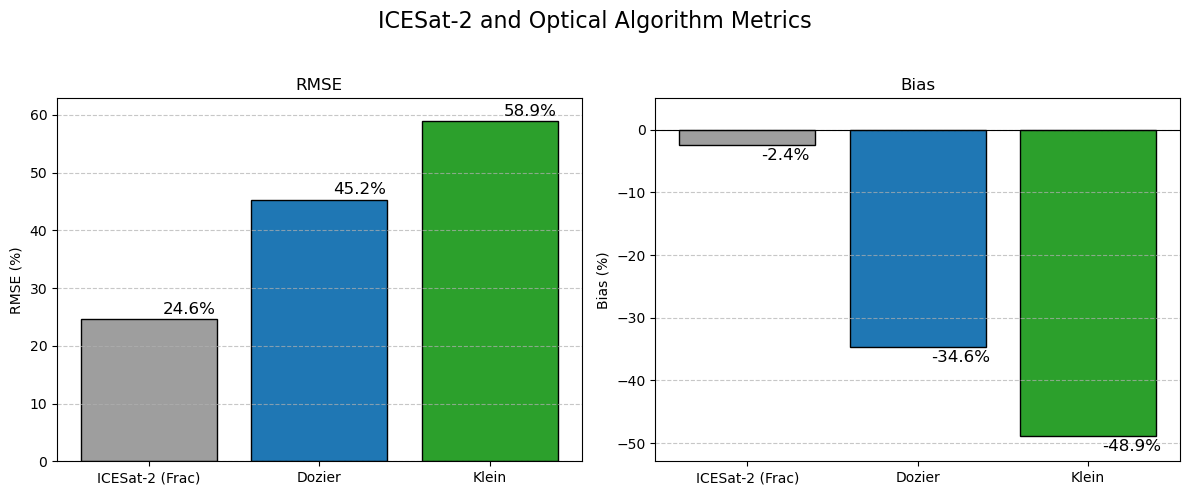

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# Expects these to already exist:
# - final_df with columns ['fsc','filtered_fraction','cam','Dozier','Klein','Salomonson']
# - overall_rmse, overall_bias, overall_frac_rmse, overall_frac_bias (from your OOF script)
# -------------------------------------------------------------------

# Compute per-method RMSE/Bias from final_df
temp = final_df[final_df['cam'].isin(['delta_junction', 'marcell_MN', 'glees'])].copy()

melted = temp.melt(
    id_vars=["fsc", "filtered_fraction", "cam"],
    value_vars=["Dozier", "Klein"],#, "Salomonson"],
    var_name="method",
    value_name="predicted"
)

def compute_rmse_bias(g):
    rmse = np.sqrt(np.mean((g["predicted"] - g["fsc"])**2)) * 100
    bias = np.mean(g["predicted"] - g["fsc"]) * 100
    return pd.Series({"RMSE": rmse, "Bias": bias})

metrics_df = melted.groupby("method", as_index=False).apply(compute_rmse_bias).reset_index(drop=True)

methods = ["Dozier", "Klein"]#, "Salomonson"]
rmse_vals = [metrics_df.loc[metrics_df["method"] == m, "RMSE"].values[0] for m in methods]
bias_vals = [metrics_df.loc[metrics_df["method"] == m, "Bias"].values[0] for m in methods]

# Add overall metrics (from OOF predictions, scaled to %)
labels = ['ICESat-2 (Frac)'] + methods
rmse_all = [overall_frac_rmse * 100] + rmse_vals
bias_all = [overall_frac_bias * 100] + bias_vals

# Colors
colors = {
    "ICESat-2 (Frac)": "#9e9e9e",
    "Dozier": "#1f77b4",
    "Klein": "#2ca02c",
    # "Salomonson": "#d62728",
}

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ax_rmse, ax_bias = axes

# RMSE panel
x_rmse = np.arange(len(labels))
bars_rmse = ax_rmse.bar(x_rmse, rmse_all,
                        color=[colors[l] for l in labels], edgecolor='black')
ax_rmse.set_xticks(x_rmse)
ax_rmse.set_xticklabels(labels, rotation=0)
ax_rmse.set_ylabel("RMSE (%)")
ax_rmse.set_title("RMSE")
ax_rmse.grid(axis='y', linestyle='--', alpha=0.7)

# Labels on bars
for bar, val in zip(bars_rmse, rmse_all):
    x_offset = bar.get_x() + bar.get_width() * 0.6
    y_offset = 0.5 * np.sign(val)  # adjust offset for %
    ax_rmse.text(x_offset, val + y_offset, f"{val:.1f}%",
                 ha='left', va='bottom' if val >= 0 else 'top', fontsize=12)

# y-limits with padding
ymin_r = min(0, min(rmse_all) - 4)
ymax_r = (max(rmse_all) + 4) if max(rmse_all) > 0 else 5
ax_rmse.set_ylim(ymin_r, ymax_r)

# Bias panel
x_bias = np.arange(len(labels))
bars_bias = ax_bias.bar(x_bias, bias_all,
                        color=[colors[l] for l in labels], edgecolor='black')
ax_bias.set_xticks(x_bias)
ax_bias.set_xticklabels(labels, rotation=0)
ax_bias.set_ylabel("Bias (%)")
ax_bias.set_title("Bias")
ax_bias.axhline(0, color='black', lw=0.8)
ax_bias.grid(axis='y', linestyle='--', alpha=0.7)

for bar, val in zip(bars_bias, bias_all):
    x_offset = bar.get_x() + bar.get_width() * 0.6
    y_offset = 0.5 * np.sign(val)
    ax_bias.text(x_offset, val + y_offset, f"{val:.1f}%",
                 ha='left', va='bottom' if val >= 0 else 'top', fontsize=12)

ymin_b = min(0, min(bias_all) - 4)
ymax_b = max(0, max(bias_all) + 4) if max(bias_all) > 0 else 5
ax_bias.set_ylim(ymin_b, ymax_b)

plt.suptitle("ICESat-2 and Optical Algorithm Metrics", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
